## `Flight Delay Prediction`
### **Part 2:** Data Cleaning and Feature Selection

Ali Bahrami

In [62]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go


from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

%matplotlib inline


In [27]:
# Read from extracted data
# Note: Null values have already been treated during the prepocessing for EDA
df_flights = pd.read_csv("data/flights.csv")

### Outlier Treatment

Text(0.5, 1.0, 'Arrival Delays without Outlier Treatment')

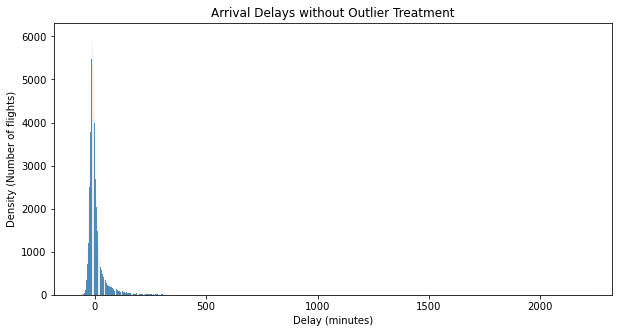

In [28]:
# From EDA Task one
# Arrival Delays without Outlier Treatment
fig, ax = plt.subplots(figsize = (10,5))
ax.set_ylabel('Density (Number of flights)')
ax.set_xlabel('Delay (minutes)')

sns.histplot(df_flights, x="arr_delay").set_title("Arrival Delays without Outlier Treatment", size=12)

In [29]:
df_flights.arr_delay.describe()

count    195872.000000
mean          5.328388
std          49.285795
min         -70.000000
25%         -15.000000
50%          -6.000000
75%           8.000000
max        2206.000000
Name: arr_delay, dtype: float64

In [30]:
# We will see an upper limit and lower limit using 3 standard deviations.
# Every data point that lies beyond the upper limit and lower limit will be an outlier.
upper = df_flights.arr_delay.mean() + 3*df_flights.arr_delay.std()
lower = df_flights.arr_delay.mean() -3*df_flights.arr_delay.std()
print(upper)
print(lower)


153.18577270733118
-142.5289968537125


In [31]:
## Filter out the outliers
df_flights = df_flights[(df_flights.arr_delay<upper) & (df_flights.arr_delay>lower)]
df_flights.head()

,fl_date,mkt_unique_carrier,tail_num,origin,origin_city_name,dest,dest_city_name,crs_dep_time,dep_time,dep_delay,...,weather_delay,nas_delay,security_delay,late_aircraft_delay,carrier,month,day_of_week,haul_length,route,flight_delayed
0,2018-05-04,DL,N754EV,BOS,"Boston, MA",RIC,"Richmond, VA",1455,1453.0,-2.0,...,0.0,0.0,0.0,0.0,Delta Air Lines,5,4,short,BOS-RIC,0
2,2019-12-20,AA,N763US,CLT,"Charlotte, NC",SAT,"San Antonio, TX",1610,1630.0,20.0,...,0.0,0.0,0.0,0.0,American Airlines,12,4,short,CLT-SAT,1
3,2019-07-14,DL,N961DL,ATL,"Atlanta, GA",PWM,"Portland, ME",2114,2114.0,0.0,...,0.0,0.0,0.0,0.0,Delta Air Lines,7,6,short,ATL-PWM,0
4,2019-04-08,AA,N679AW,PHX,"Phoenix, AZ",BOI,"Boise, ID",2021,2015.0,-6.0,...,0.0,0.0,0.0,0.0,American Airlines,4,0,short,PHX-BOI,0
5,2019-12-26,UA,N464UA,LAS,"Las Vegas, NV",DEN,"Denver, CO",1645,1641.0,-4.0,...,0.0,0.0,0.0,0.0,United Airlines,12,3,short,LAS-DEN,0


Text(0.5, 1.0, 'Arrival Delays  Post-outlier Treatment')

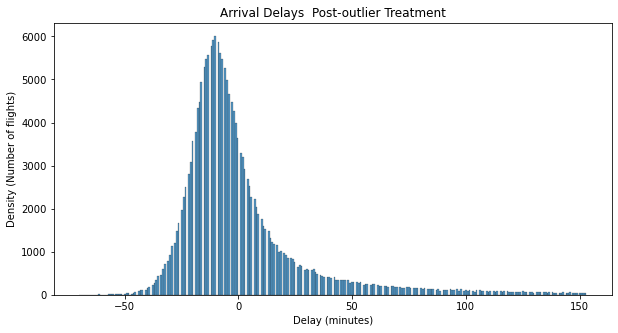

In [32]:
# Arrival Delays Post-outlier Treatment
fig, ax = plt.subplots(figsize = (10,5))
ax.set_ylabel('Density (Number of flights)')
ax.set_xlabel('Delay (minutes)')

sns.histplot(df_flights, x="arr_delay").set_title("Arrival Delays  Post-outlier Treatment", size=12)

In [33]:
df_flights.shape

(192723, 34)

## Drop Unnecessary Columns 

Drop the columns that we will not be using in the modeling

In [34]:
cols = ['fl_date', 'mkt_unique_carrier', 'tail_num',
       'origin_city_name', 'dest_city_name',
       'dep_time', 'taxi_out', 'wheels_off', 'wheels_on',
       'taxi_in', 'arr_time', 'cancelled', 'dup',
       'actual_elapsed_time',
       'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay',
       'late_aircraft_delay', 'flight_delayed',
       'haul_length', 'route']
df_flights = df_flights.drop(columns=cols)

In [35]:
df_flights.head()

,origin,dest,crs_dep_time,dep_delay,crs_arr_time,arr_delay,crs_elapsed_time,air_time,distance,carrier,month,day_of_week
0,BOS,RIC,1455,-2.0,1649,-14.0,114.0,78.0,474.0,Delta Air Lines,5,4
2,CLT,SAT,1610,20.0,1822,19.0,192.0,171.0,1095.0,American Airlines,12,4
3,ATL,PWM,2114,0.0,2355,-14.0,161.0,133.0,1027.0,Delta Air Lines,7,6
4,PHX,BOI,2021,-6.0,2330,-14.0,129.0,101.0,735.0,American Airlines,4,0
5,LAS,DEN,1645,-4.0,1937,-17.0,112.0,82.0,628.0,United Airlines,12,3


## Feature Engineer Time-Related Data

In [38]:
def bin_hours(time):
    # Bin the time from HHMM input format to 24 hrs where 23=11pm and 0=12am
    if type(time) == 'numpy.ndarray':
        time = time.astype(int)
    time = int(time)
    
    t = time // 100
    
    if t == 0:
        return 0
    return t

In [39]:
# Bin the departure time into hours
df_flights.loc[:,'crs_dep_time'] = df_flights['crs_dep_time'].apply(bin_hours)
df_flights.loc[:,'crs_arr_time'] = df_flights['crs_arr_time'].apply(bin_hours)

In [40]:
mean_hist_dep_delay = df_flights.groupby(['crs_dep_time'])['dep_delay'].mean().reset_index().rename(columns={'dep_delay': 'mean_hist_dep_delay'})
mean_hist_arr_delay = df_flights.groupby(['crs_arr_time'])['arr_delay'].mean().reset_index().rename(columns={'arr_delay': 'mean_hist_arr_delay'})

mean_hist_dep_delay.head(50)

,crs_dep_time,mean_hist_dep_delay
0,0,7.293556
1,1,5.870968
2,2,26.692308
3,3,10.780488
4,4,13.666667
5,5,-1.430416
6,6,-0.743775
7,7,0.845592
8,8,2.072657
9,9,3.246698


In [41]:
merged = pd.merge(df_flights, mean_hist_dep_delay, on=['crs_dep_time'], how='left')
df_flights = pd.merge(merged, mean_hist_arr_delay, on=['crs_arr_time'], how='left')

In [42]:
df_flights

,origin,dest,crs_dep_time,dep_delay,crs_arr_time,arr_delay,crs_elapsed_time,air_time,distance,carrier,month,day_of_week,mean_hist_dep_delay,mean_hist_arr_delay
0,BOS,RIC,14,-2.0,16,-14.0,114.0,78.0,474.0,Delta Air Lines,5,4,7.857507,1.722365
1,CLT,SAT,16,20.0,18,19.0,192.0,171.0,1095.0,American Airlines,12,4,9.247318,4.573334
2,ATL,PWM,21,0.0,23,-14.0,161.0,133.0,1027.0,Delta Air Lines,7,6,10.701001,4.330997
3,PHX,BOI,20,-6.0,23,-14.0,129.0,101.0,735.0,American Airlines,4,0,11.688123,4.330997
4,LAS,DEN,16,-4.0,19,-17.0,112.0,82.0,628.0,United Airlines,12,3,9.247318,5.387877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192718,IAD,SCE,12,-13.0,13,-14.0,67.0,42.0,133.0,United Airlines,2,3,5.309485,-0.927422
192719,CLT,FLL,16,-2.0,18,3.0,123.0,93.0,632.0,American Airlines,9,4,9.247318,4.573334
192720,JAX,ORD,19,-7.0,21,-20.0,160.0,117.0,864.0,American Airlines,7,4,11.023786,5.265583
192721,CLT,GSO,14,-4.0,15,-7.0,53.0,26.0,83.0,American Airlines,1,1,7.857507,0.924549


In [47]:
df_flights.columns

Index(['origin', 'dest', 'crs_dep_time', 'dep_delay', 'crs_arr_time',
       'arr_delay', 'crs_elapsed_time', 'air_time', 'distance', 'carrier',
       'month', 'day_of_week', 'mean_hist_dep_delay', 'mean_hist_arr_delay'],
      dtype='object')

In [48]:
# label encode origin and destination or drop it. UPDATE: label encoding it for now

# cols = ['origin', 'dest']
# df_flights = df_flights.drop(columns=cols)

## Label Encode

In [49]:
# Origin
le_origin = LabelEncoder()
le_origin.fit(df_flights.origin)
df_flights.loc[:,"origin"] = le_origin.transform(df_flights.origin)

In [50]:
# Dest
le_dest = LabelEncoder()
le_dest.fit(df_flights.dest)
df_flights.loc[:,"dest"] = le_dest.transform(df_flights.dest)

In [51]:
# Carrier
le_carrier = LabelEncoder()
le_carrier.fit(df_flights.carrier)
df_flights.loc[:,"carrier"] = le_carrier.transform(df_flights.carrier)

## Get Dummies

Will be using the labelencode library instead

In [52]:
# get dummies for all categoricals
# drop_first=True is important to use, as it helps in reducing the extra column created during dummy variable creation.
# Hence it reduces the correlations created among dummy variables.

# crs_dep_time_dummies = pd.get_dummies(df_flights['crs_dep_time'], prefix='crs_dep_time', drop_first=True)
# crs_arr_time_dummies = pd.get_dummies(df_flights['crs_arr_time'], prefix='crs_arr_time', drop_first=True)
# carrier_dummies = pd.get_dummies(df_flights['carrier'], prefix='carrier', drop_first=True)
# month_dummies = pd.get_dummies(df_flights['month'], prefix='month', drop_first=True)
# day_of_week_dummies = pd.get_dummies(df_flights['day_of_week'], prefix='day_of_week', drop_first=True)


In [53]:
# df_flights = pd.concat([df_flights, crs_dep_time_dummies, crs_arr_time_dummies, carrier_dummies, month_dummies, day_of_week_dummies], axis=1)

In [54]:
# Drop the original columns
# df_flights = df_flights.drop(['crs_dep_time', 'crs_arr_time', 'carrier', 'month', 'day_of_week'], axis=1)

In [55]:
df_flights.dtypes

origin                   int64
dest                     int64
crs_dep_time             int64
dep_delay              float64
crs_arr_time             int64
arr_delay              float64
crs_elapsed_time       float64
air_time               float64
distance               float64
carrier                  int64
month                    int64
day_of_week              int64
mean_hist_dep_delay    float64
mean_hist_arr_delay    float64
dtype: object

In [56]:
df_flights.head()

,origin,dest,crs_dep_time,dep_delay,crs_arr_time,arr_delay,crs_elapsed_time,air_time,distance,carrier,month,day_of_week,mean_hist_dep_delay,mean_hist_arr_delay
0,46,297,14,-2.0,16,-14.0,114.0,78.0,474.0,3,5,4,7.857507,1.722365
1,73,308,16,20.0,18,19.0,192.0,171.0,1095.0,2,12,4,9.247318,4.573334
2,21,290,21,0.0,23,-14.0,161.0,133.0,1027.0,3,7,6,10.701001,4.330997
3,271,44,20,-6.0,23,-14.0,129.0,101.0,735.0,2,4,0,11.688123,4.330997
4,193,92,16,-4.0,19,-17.0,112.0,82.0,628.0,9,12,3,9.247318,5.387877


In [57]:
df_flights.shape

(192723, 14)

In [58]:
# we cannot use dep delay directly to predict, so i will drop it. 
cols = ['dep_delay']
df_flights = df_flights.drop(columns=cols)

## Scale the data and prepare it for modeling

In [67]:
df_model = df_flights.copy()

In [68]:
y = df_model['arr_delay']
X = df_model.drop(['arr_delay'], axis = 1)

In [69]:
scaler = StandardScaler()
scaler.fit(X)
scaled_df = scaler.fit_transform(X)

In [70]:
df_flights.columns

Index(['origin', 'dest', 'crs_dep_time', 'crs_arr_time', 'arr_delay',
       'crs_elapsed_time', 'air_time', 'distance', 'carrier', 'month',
       'day_of_week', 'mean_hist_dep_delay', 'mean_hist_arr_delay'],
      dtype='object')

In [72]:
flights_scaled = pd.DataFrame(data = scaled_df,
              columns = ['origin', 'dest', 'crs_dep_time', 'crs_arr_time',
       'crs_elapsed_time', 'air_time', 'distance', 'carrier', 'month',
       'day_of_week', 'mean_hist_dep_delay', 'mean_hist_arr_delay'])

In [73]:
flights_scaled = flights_scaled.merge(y, right_index=True, left_index=True)
flights_scaled

,origin,dest,crs_dep_time,crs_arr_time,crs_elapsed_time,air_time,distance,carrier,month,day_of_week,mean_hist_dep_delay,mean_hist_arr_delay,arr_delay
0,-1.345799,1.158846,0.206656,0.287511,-0.333014,-0.426846,-0.503081,-0.591517,-0.467353,0.531350,0.435436,0.192550,-14.0
1,-1.078859,1.268110,0.616548,0.674710,0.755372,0.909863,0.556498,-0.937630,1.590690,0.531350,0.784969,0.945652,19.0
2,-1.592966,1.089314,1.641278,1.642706,0.322809,0.363681,0.440473,-0.591517,0.120659,1.535334,1.150566,0.881637,-14.0
3,0.878702,-1.354240,1.436332,1.642706,-0.123709,-0.096262,-0.057751,-0.937630,-0.761359,-1.476618,1.398824,0.881637,-14.0
4,0.107542,-0.877449,0.616548,0.868309,-0.360921,-0.369353,-0.240319,1.485162,1.590690,0.029358,0.784969,1.160819,-17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
192718,-0.159398,1.337642,-0.203236,-0.293287,-0.988836,-0.944281,-1.084912,1.485162,-1.349372,0.029358,-0.205384,-0.507409,-14.0
192719,-1.078859,-0.549655,0.616548,0.674710,-0.207431,-0.211248,-0.233494,-0.937630,0.708672,0.531350,0.784969,0.945652,3.0
192720,0.008675,0.731720,1.231386,1.255508,0.308855,0.133710,0.162355,-0.937630,0.120659,0.531350,1.231745,1.128514,-20.0
192721,-1.078859,-0.370858,0.206656,0.093912,-1.184188,-1.174253,-1.170224,-0.937630,-1.643378,-0.974626,0.435436,-0.018198,-7.0


In [75]:
flights_scaled.to_csv("data/flights_model.csv", index=False)